In [2]:
RANDOM_STATE = 3956

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.special
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

In [5]:
class TransformerStep(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    def transform(self, X):
        raise NotImplementedError("transform method should be implemented!")

In [6]:
class PerColumnsStackRest(TransformerStep):
    def __init__(self, *columns_pipeline_map):
        self.columns_pipeline_map = columns_pipeline_map
    def fit(self, X, y=None, **fit_params):
        for columns, pipeline in self.columns_pipeline_map:
            pipeline.fit(X.loc[:, columns], y, **fit_params)
        return self
    def transform(self, X):
        processed = []
        rest_columns = set(X.columns)
        for columns, pipeline in self.columns_pipeline_map:
            processed.append(pipeline.transform(X.loc[:, columns]))
            rest_columns -= set(columns)
        if rest_columns:
            processed.append(X.loc[:, rest_columns])
        concatenated = pd.concat(processed, axis=1)
        return concatenated

In [7]:
class ZerosToAgg(TransformerStep):
    def __init__(self, agg=np.median):
        self.central = 0
        self.agg = agg
    def fit(self, X, y=None, **fit_params):
        zeros = (X == 0).values
        self.central = self.agg(X[~zeros])
        return self
    def transform(self, X):
        res = X.copy()
        res_zeros = (res == 0).values
        res[res_zeros] = self.central
        return res

In [8]:
class ZerosToHistogram(TransformerStep):
    def __init__(self):
        self.generator = None
    def fit(self, X, y=None, **fit_params):
        zeros = (X == 0).values
        self.generator = sp.stats.rv_histogram(np.histogram(X[~zeros]))
        return self
    def transform(self, X):
        res = X.copy()
        res_zeros = (res == 0).values
        res[res_zeros] = self.generator.rvs(size=res_zeros.shape, random_state=RANDOM_STATE)
        return res

In [9]:
class VectorizedTransformer(TransformerStep):
    def __init__(self, step_class, *args, **kwargs):
        self.step_class = step_class
        self.step_args = args
        self.step_kwargs = kwargs
        self.step_per_col = []
    def fit(self, X, y=None, **fit_params):
        for col in X.columns:
            step = self.step_class(*self.step_args, **self.step_kwargs)
            step.fit(X.loc[:, [col]], y, **fit_params)
            self.step_per_col.append(step)
        return self
    def transform(self, X):
        assert len(X.columns) == len(self.step_per_col)
        res = []
        for i, col in enumerate(X.columns):
            res.append(self.step_per_col[i].transform(X.loc[:, [col]]))
        return pd.concat(res, axis=1)

In [10]:
class DataFrameStep(TransformerStep):
    def __init__(self, step):
        self.step = step
    def fit(self, X, y=None, **fit_params):
        self.step.fit(X, y, **fit_params)
        return self
    def transform(self, X):
        transformed = self.step.transform(X)
        return pd.DataFrame(transformed, index=X.index, columns=X.columns)

In [11]:
class PoissonToNormal(TransformerStep):
    """ https://en.wikipedia.org/wiki/Anscombe_transform """
    def transform(self, X):
        return 2*np.sqrt(X + 3/8)

In [12]:
class ExpToNormal(TransformerStep):
    def __init__(self):
        self.mean = 0
    def fit(self, X, y=None, **fit_params):
        self.mean = sp.mean(X, axis=0)
        return self
    def transform(self, X):
        res = sp.special.erfinv(1 - np.exp(-X/self.mean))
        return res

In [13]:
class DebugStep(TransformerStep):
    def fit(self, X, y=None, **fit_params):
        import ipdb; ipdb.set_trace();
        return self
    def transform(self, X):
        import ipdb; ipdb.set_trace();
        return X

In [14]:
def model_report(model, X_test, y_test):
    print(f"Score: {f1_score(model.predict(X_test), y_test)}")
    
    confusion = confusion_matrix(y_test, model.predict(X_test))
    print("Confusion matrix:")
    display(confusion)
    
    
    print("Precision recall fscore support:")
    prfs = precision_recall_fscore_support(y_test, model.predict(X_test))
    display(prfs)
    
    print("Model params")
    if hasattr(model, "best_params_"):
        display(model.best_params_)
    else:
        display(model.get_params())
    
    if hasattr(model, "cv_results_"):
        compiled = [pd.DataFrame(model.cv_results_["mean_test_score"], columns=["mean_test_score"]),
                    pd.DataFrame(model.cv_results_["std_test_score"], columns=["std_test_score"]),
                    pd.DataFrame(model.cv_results_["params"]).add_prefix("param__")]
        compiled_df = pd.concat(compiled, axis=1)
        
        print("All score-params:")
        display(compiled_df)

In [15]:
data = pd.read_csv("data/pima.csv")
display(data.head())
display(data.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2b09818d0>,
      dtype=object)

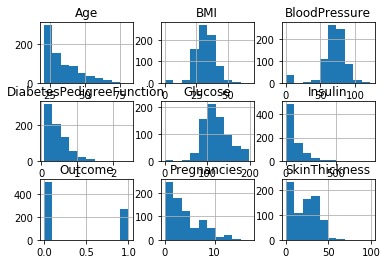

In [16]:
data.hist()

In [17]:
X = data.drop(columns=["Outcome", "Insulin"])
y = data["Outcome"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2b05c76d8>,
      dtype=object)

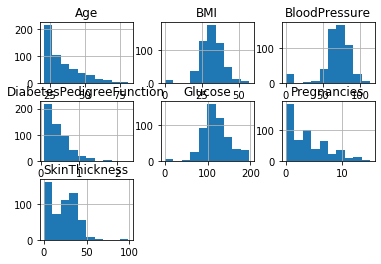

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)
X_train.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb2afe50f98>,
      dtype=object)

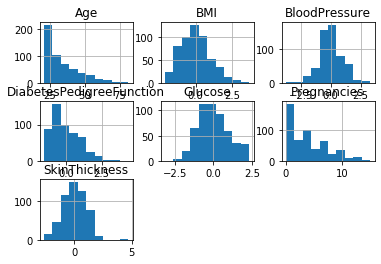

In [19]:
features_pipeline = lambda: make_pipeline(
    PerColumnsStackRest(
        (['BloodPressure', 'SkinThickness', 'BMI', 'Glucose'],
         VectorizedTransformer(lambda: ZerosToHistogram()))
    ),
    PerColumnsStackRest(
        (['Glucose', 'SkinThickness'], PoissonToNormal()),
        (['DiabetesPedigreeFunction'], ExpToNormal())
    ),
    PerColumnsStackRest(
        (['BloodPressure', 'SkinThickness', 'BMI','Glucose', 'DiabetesPedigreeFunction'],
         VectorizedTransformer(lambda: DataFrameStep(StandardScaler(copy=True))))
    )
)

features_pipeline().fit(X_train, y_train).transform(X_train).hist()

In [20]:
def logreg():
    from sklearn.linear_model import LogisticRegression

    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", LogisticRegression(random_state=RANDOM_STATE, solver="lbfgs"))
    ])

    model = GridSearchCV(pipeline,
                         {"estimator__C": [0.01, 0.03, 0.06, 0.1, 0.15, 0.45, 1],
                          "estimator__tol": [1E-8, 1E-7, 1E-6, 1E-5],
                          "estimator__max_iter": [450, 500, 550]},
                         cv=3, scoring='f1', error_score='raise')
    model.fit(X_train, y_train)
    return model

In [21]:
def knn():
    from sklearn.neighbors import KNeighborsClassifier
    
    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", KNeighborsClassifier())
    ])
    
    model = GridSearchCV(pipeline,
                         {"estimator__n_neighbors": [1,2,3,4,5, 7, 10, 50, 80],
                          "estimator__p": [1, 2]},
                         cv=3, scoring='f1', error_score='raise')
    model.fit(X_train, y_train)
    return model

In [22]:
def dectree():
    from sklearn.tree import DecisionTreeClassifier
    
    pipeline = Pipeline([
        ("features", features_pipeline()),
        ("estimator", DecisionTreeClassifier(random_state=RANDOM_STATE))
    ])
    
    model = pipeline
    model.fit(X_train, y_train)
    return model

In [23]:
model = logreg()

/home/vindex10/projects/.venvs/sandbox/lib64/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [24]:
model_report(model, X_test, y_test)

Score: 0.6335403726708074
Confusion matrix:


array([[121,  24],
       [ 35,  51]])

Precision recall fscore support:


(array([0.77564103, 0.68      ]),
 array([0.83448276, 0.59302326]),
 array([0.80398671, 0.63354037]),
 array([145,  86]))

Model params


{'estimator__C': 0.45, 'estimator__max_iter': 450, 'estimator__tol': 1e-08}

All score-params:


,mean_test_score,std_test_score,param__estimator__C,param__estimator__max_iter,param__estimator__tol
0,0.534390,0.050321,0.01,450,1.000000e-08
1,0.534390,0.050321,0.01,450,1.000000e-07
2,0.534390,0.050321,0.01,450,1.000000e-06
3,0.534390,0.050321,0.01,450,1.000000e-05
4,0.534390,0.050321,0.01,500,1.000000e-08
5,0.534390,0.050321,0.01,500,1.000000e-07
6,0.534390,0.050321,0.01,500,1.000000e-06
7,0.534390,0.050321,0.01,500,1.000000e-05
8,0.534390,0.050321,0.01,550,1.000000e-08
9,0.534390,0.050321,0.01,550,1.000000e-07
